In [68]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import QuantLib as ql
import xlwings as xw


In [69]:
# from quant_lib import curve as cv

In [71]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/project_FICC_Quant/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/project_FICC_Quant
changed directory is :  /mnt/c/workspace/project_FICC_Quant


## What is swap rate?
Swap rate is interest rate which is reflect credibility among banks.
Since banks are major players of Over-The-Counter(OTC) market, special interest rate is needed.

## What is difference?
Each player in finance industry has different credibility. Credibility of US government, Korea government, JP Morgan bank , Korea industrial bank and me have different credibility. When these banks are trading derivative product in OTC market, special interest rate called swap rate curve which is different from treasury yield, corporate bond rate is needed.

## What are needed?
(1)Libor rate, (2)Euro dollar futures and (3)Swap rate is needed to calculate interest rate swap curve.


## How to construct Term Structure
Use bootstrap helper class in QuantLib
#### TermStructure() = DepositRateHelper() + FuturesRateHelper() + SwapRateHelper()   
DepositRateHelper = helper for short term LIBOR rate   
FuturesRateHelper = helper to extract interest rate implied in Euro Dollar futures contract   
SwapRateHelper = helper for swap rate longer than 2 years   

In [72]:
# Get quote data from excel
# swap related data is difficult to get from usual internet site
# data is from bloomberg terminal

#import data from excel
def get_quote(today=None):
    # get data without opening excel file
    app = xw.App(visible=False)
    # get excel
    # wb = xw.Book(r'/mnt/c/workspace/project_FICC_Quant/market_data/swap_data.xlsx')
    wb = xw.Book(os.path.join(os.getcwd(), "market_data/swap_data.xlsx")) 
    # select which sheets to use
    sht = wb.Sheets('Sheet1') 
    # set range of input and return in dataframe form
    quote = sht.range('A1:D25').options(pd.DataFrame).value 
    print(quote)
    # terminate excel file
    wb.close() 
    return quote

In [79]:
def get_quote(today):
    quote = pd.read_excel(os.path.join(os.getcwd(), "market_data/swap_data.xlsx"),index_col='Tenor')
    # pre-processing dataframe
    quote['DaysToMaturity'] = np.nan
    quote['Maturity'] = pd.to_datetime(quote['Maturity']).dt.date

    for tenor in quote.index:
        quote.loc[tenor, 'DaysToMaturity'] = (quote.loc[tenor, 'Maturity'] - today).days
    return quote

In [74]:
# construct IRS curve
def swap_curve(today, quote):

    # divide dataframe into 3 parts
    depo = quote[quote['InstType'] == 'CASH']
    futures = quote[quote['InstType'] == 'FUTURES']
    swap = quote[quote['InstType'] == 'SWAP']

    # Set evaluation date
    todays_date = ql.Date(today.day, today.month, today.year)
    ql.Settings.instance().evaluationDate = todays_date

    #Market Conventions
    calendar = ql.UnitedStates()
    dayCounter = ql.Actual360()
    convention = ql.ModifiedFollowing
    settlementDays = 2
    frequency = ql.Semiannual

    ### Build Rate Helper ###

    # 1_Deposit rate helper
    depositHelpers = [
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(rate/100)),
            ql.Period(int(day), ql.Days),
            settlementDays,
            calendar,
            convention,
            False,
            dayCounter
        )
        for day, rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])
    ]

    # 2_ Futures rate helper
    futuresHelpers = []
    for i, price in enumerate(futures['Market.Mid']):
        iborStartDate = ql.Date(
            futures['Maturity'][i].day,
            futures['Maturity'][i].month,
            futures['Maturity'][i].year
        )
        
        futuresHelpers = ql.FuturesRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(price)),
            iborStartDate,
            3,
            calendar,
            convention,
            False,
            dayCounter
        )
        futuresHelpers.append(futuresHelpers)

    # 3_ Swap rate helper
    swapHelpers = [ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(rate/100)),
        ql.Period(int(day), ql.Days),
        calendar,
        frequency,
        convention,
        dayCounter,
        ql.Euribor3M()
        )
        for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])
    ]

    # Combine 1_2_3 with Piece wise linear zero method
    # Curve construction
    helpers = depositHelpers + futuresHelpers + swapHelpers
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter)

    return depoFuturesSwapCurve

In [75]:
# use curve to compute discount factor and zero rate
# the curve is calcualted with module used while pricing treasury
def discount_factor(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

def zero_rate(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.Actual360()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(
        date,
        day_counter,
        compounding,
        freq
    ).rate()

    return zero_rate

In [76]:
# cacualte forward rate
def forward_rate(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.Actual360()
    compounding = ql.Compounded
    freq = ql.Continuous
    forward_rate = curve.forwardRate(
        date,
        date,
        day_counter,
        compounding,
        freq,
        True
    ).rate()
    
    return forward_rate

Let's run the code

In [77]:
today = datetime.date(2020,10,9)

In [80]:
today = datetime.date(2020,10,9)
quote = get_quote(today=today)
quote

,Maturity,InstType,Market.Mid,DaysToMaturity
Tenor,,,,
3MO,2021-01-09,CASH,0.22538,92.0
6MO,2021-03-17,FUTURE,99.72500,159.0
9MO,2021-06-16,FUTURE,99.78500,250.0
12MO,2021-09-15,FUTURE,99.80000,341.0
15MO,2021-12-15,FUTURE,99.80000,432.0
18MO,2022-03-16,FUTURE,99.78000,523.0
21MO,2022-06-15,FUTURE,99.80000,614.0
2Y,2022-10-07,SWAP,0.21815,728.0
3Y,2023-10-09,SWAP,0.23010,1095.0


In [82]:
curve = swap_curve(today=today, quote=quote)
curve

<QuantLib.QuantLib.PiecewiseLinearZero; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLinearZero > *' at 0x7f9f8b411780> >

In [83]:
# calculate discount factor/ zero rate/ forward rate
quote['discount_factor'], quote['zero_rate'], quote['forward_rate'] = np.nan, np.nan, np.nan

for tenor, date in zip(quote.index, quote['Maturity']):
    quote.loc[tenor, 'discount_factor'] = discount_factor(date, curve)
    quote.loc[tenor, 'zero_rate'] = zero_rate(date, curve) * 100
    quote.loc[tenor, 'forward_rate'] = forward_rate(date, curve) * 100

In [84]:
# print result
print(quote[['discount_factor', 'zero_rate', 'forward_rate']])

       discount_factor  zero_rate  forward_rate
Tenor                                          
3MO           0.999424   0.225410      0.225410
6MO           0.999006   0.225213      0.223262
9MO           0.998446   0.224097      0.221029
12MO          0.997891   0.222980      0.218796
15MO          0.997343   0.221863      0.216563
18MO          0.996800   0.220747      0.214329
21MO          0.996263   0.219630      0.212096
2Y            0.995599   0.218231      0.209299
3Y            0.993033   0.229976      0.265555
4Y            0.989204   0.267638      0.419189
5Y            0.983540   0.327478      0.628952
6Y            0.976198   0.396210      0.809997
7Y            0.967113   0.471725      1.003116
8Y            0.956853   0.544133      1.121227
9Y            0.945523   0.614450      1.248637
10Y           0.933515   0.679342      1.328857
11Y           0.921174   0.737188      1.373633
12Y           0.908723   0.787884      1.396338
15Y           0.871961   0.902431      1

Text(0, 0.5, 'interst rate')

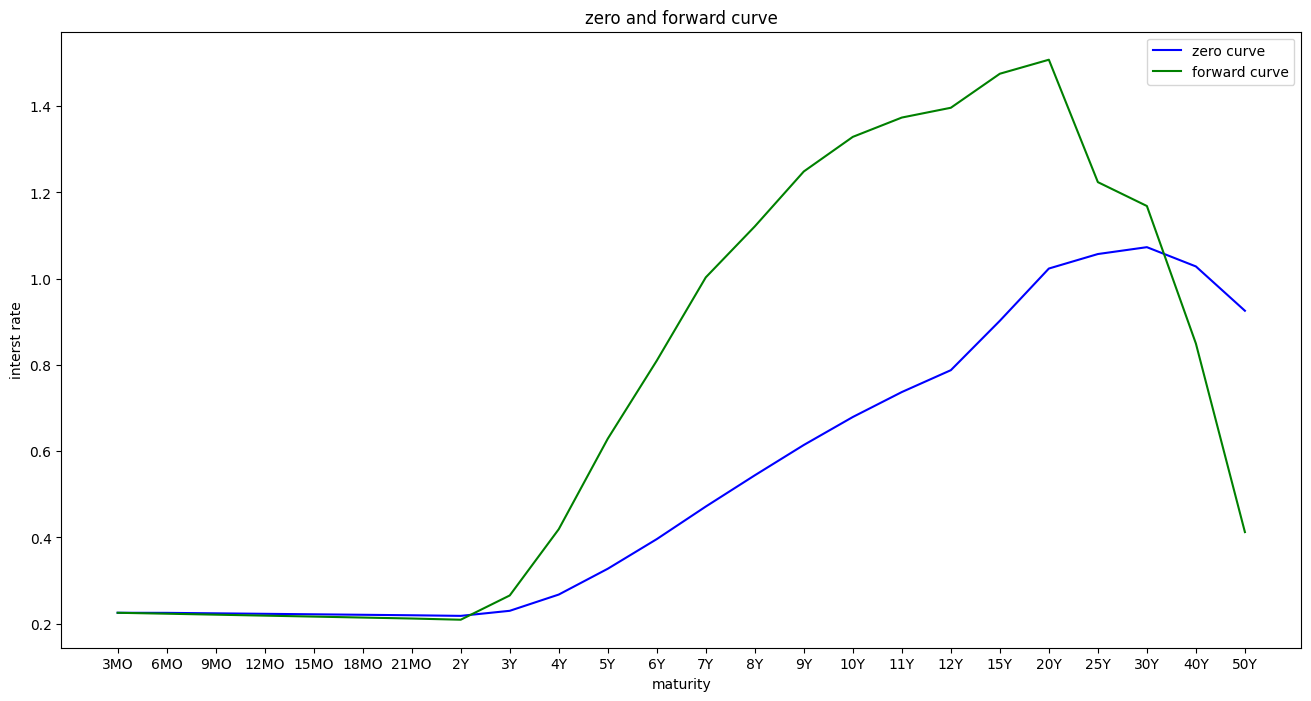

In [85]:
# plot the result
plt.figure(figsize=(16,8))
plt.plot(quote['zero_rate'], 'b-', label='zero curve')
plt.plot(quote['forward_rate'], 'g-', label='forward curve')
plt.title('zero and forward curve', loc='center')
plt.legend()
plt.xlabel('maturity')
plt.ylabel('interst rate')

Text(0, 0.5, 'discount factor')

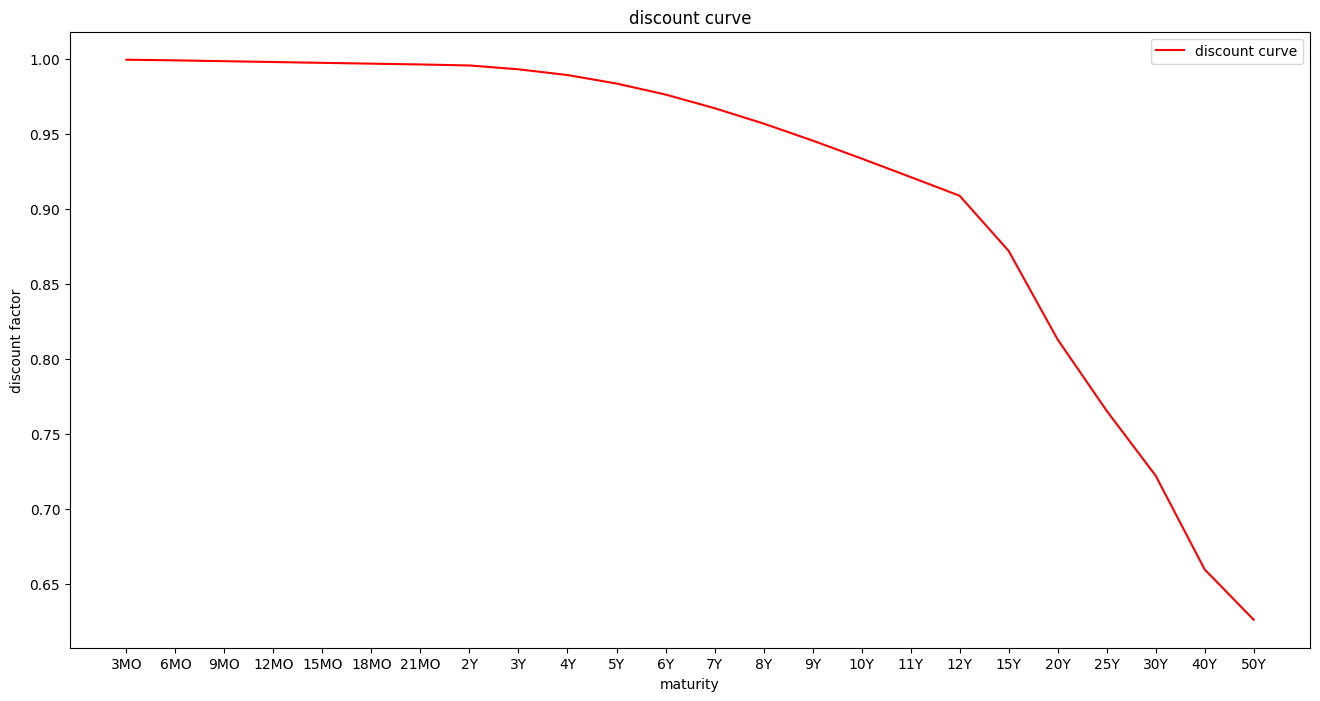

In [86]:
# plot the result
plt.figure(figsize=(16,8))
plt.plot(quote['discount_factor'], 'r-', label='discount curve')
plt.title('discount curve', loc='center')
plt.legend()
plt.xlabel('maturity')
plt.ylabel('discount factor')